In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive

#Mount Google Drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [3]:
# Define the path to the excel file (replace with your file path on Google Drive)
file_path = '/content/MyDrive/MyDrive/df14.csv'

In [5]:
# Read the .csv file into a DataFrame
df = pd.read_csv(file_path)

In [6]:
# Display the first few rows of the DataFrame
print(df.head())

              Datetime        NO2       PM10     PM2.5     RH       Temp  \
0  2018-01-01 00:00:00  64.216400  14.020000  6.980000  65.84  20.880000   
1  2018-01-01 01:00:00  46.040667  15.966667  8.900000  65.84  21.116667   
2  2018-01-01 02:00:00  28.285000  12.050000  5.183333  65.84  20.716667   
3  2018-01-01 03:00:00  24.381333  12.750000  5.133333  65.84  20.383333   
4  2018-01-01 04:00:00  21.431167  10.700000  4.250000  65.84  20.466667   

           WD        WS  
0   80.880000  0.300000  
1  152.250000  0.233333  
2  163.016667  0.266667  
3   55.550000  0.233333  
4   33.583333  0.250000  


In [7]:
# Calculate the percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Print the missing percentage per column
print("Percentage of missing values per column:")
print(missing_percentage)

Percentage of missing values per column:
Datetime    0.0
NO2         0.0
PM10        0.0
PM2.5       0.0
RH          0.0
Temp        0.0
WD          0.0
WS          0.0
dtype: float64


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load dataset (ensure 'Datetime' is parsed correctly)
df = pd.read_csv(file_path, parse_dates=["Datetime"], index_col="Datetime")

# Select features (excluding PM2.5 itself to prevent data leakage)
features = ["NO2", "PM10", "RH", "Temp", "WD", "WS"]

# Create lag features for NO2
for lag in range(1, 25):  # Using past 24 hours of NO2 data
    df[f"PM2.5_lag{lag}"] = df["PM2.5"].shift(lag)

# Drop NaN values after lag creation
df = df.dropna()

# Define X (independent variables) and y (target variable)
X = df[features + [f"PM2.5_lag{lag}" for lag in range(1, 25)]]
y = df["PM2.5"]

# Standardize features (not target variable)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
#train test split
train_size = int(0.8 * len(df))  # 80% training, 20% testing
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
#Train the Random Forest Model
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [11]:
#Evaluate model performance
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove squared parameter
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

In [12]:
# Print metrics
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

MAE: 0.656
RMSE: 1.711
R² Score: 0.757


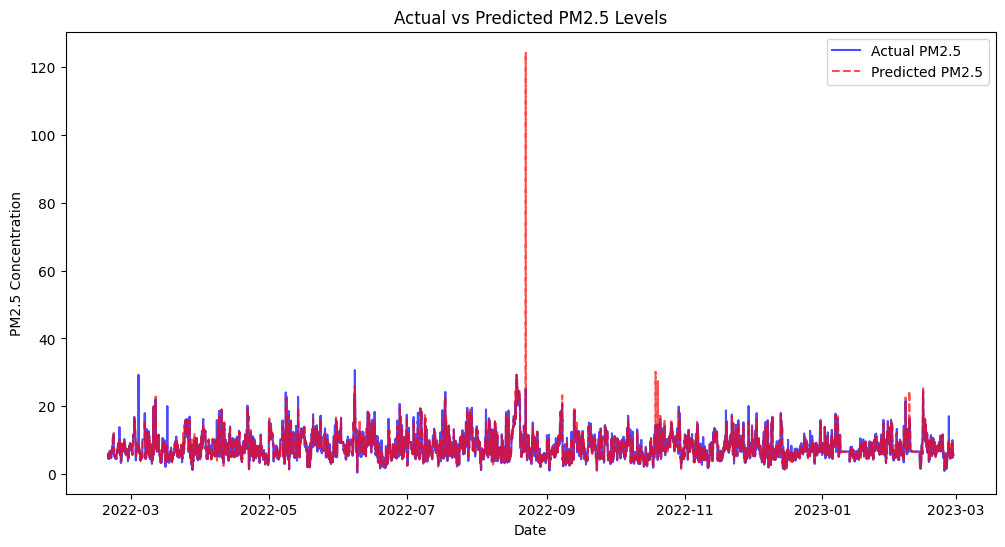

In [13]:
#visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual PM2.5", color="blue", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted PM2.5", color="red", linestyle="dashed", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.title("Actual vs Predicted PM2.5 Levels")
plt.legend()
plt.show()

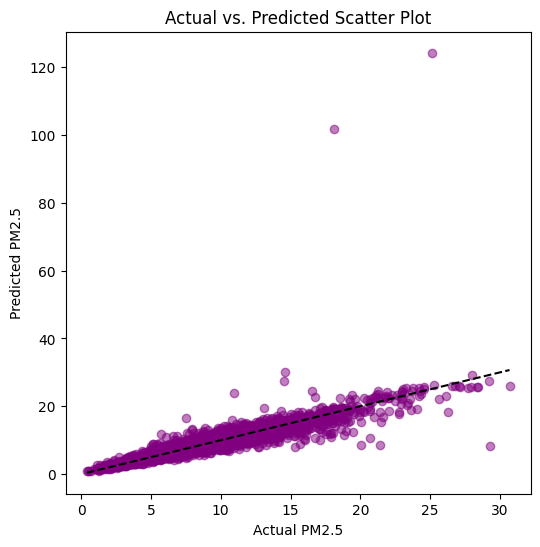

In [14]:
#Scatter Plot for Correlation
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="purple")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="black")  # 45-degree line
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs. Predicted Scatter Plot")
plt.show()

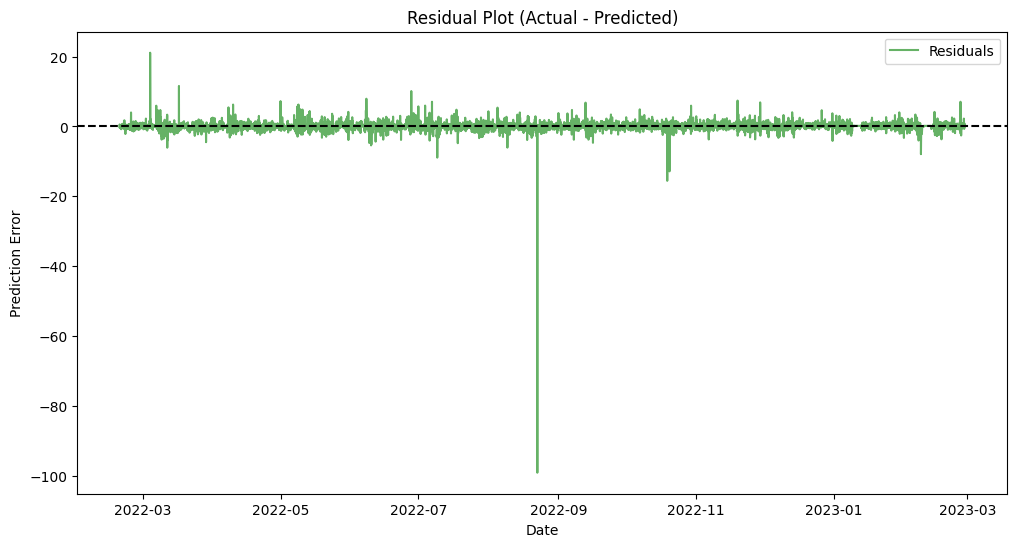

In [15]:
#Residual Plot (Errors Over Time)
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, label="Residuals", color="green", alpha=0.6)
plt.axhline(0, linestyle="dashed", color="black")
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.title("Residual Plot (Actual - Predicted)")
plt.legend()
plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [17]:
# Define parameter grid for RandomizedSearchCV
random_grid = {
    "n_estimators": [50, 100, 200, 500],  # Number of trees
    "max_depth": [10, 20, 30, None],  # Depth of each tree
    "min_samples_split": [2, 5, 10],  # Minimum samples per split
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
    "max_features": ["auto", "sqrt"],  # Features considered per split
    "bootstrap": [True, False]  # Use bootstrap sampling
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV (faster search)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=random_grid,
    n_iter=20,  # Number of random configurations
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Best model
best_rf_random = random_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
27 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent

Best Parameters from RandomizedSearchCV: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [17]:
# Define parameter grid for GridSearchCV (based on best results from RandomizedSearchCV)
param_grid = {
    "n_estimators": [100, 200, 300],  # Fine-tuning number of trees
    "max_depth": [20, 30],  # Depth of trees
    "min_samples_split": [2, 5],  # Min samples per split
    "min_samples_leaf": [1, 2],  # Min samples per leaf
    "max_features": ["auto", "sqrt"],  # Features considered per split
    "bootstrap": [True]  # Fix bootstrap if determined earlier
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# Best model
best_rf_grid = grid_search.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", l

Best Parameters from GridSearchCV: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [19]:
# Make predictions with the best Random Forest model
y_pred = best_rf_grid.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove 'squared' parameter
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Optimized Random Forest - MAE: {mae:.3f}")
print(f"Optimized Random Forest - RMSE: {rmse:.3f}")
print(f"Optimized Random Forest - R² Score: {r2:.3f}")

Optimized Random Forest - MAE: 0.708
Optimized Random Forest - RMSE: 1.188
Optimized Random Forest - R² Score: 0.883


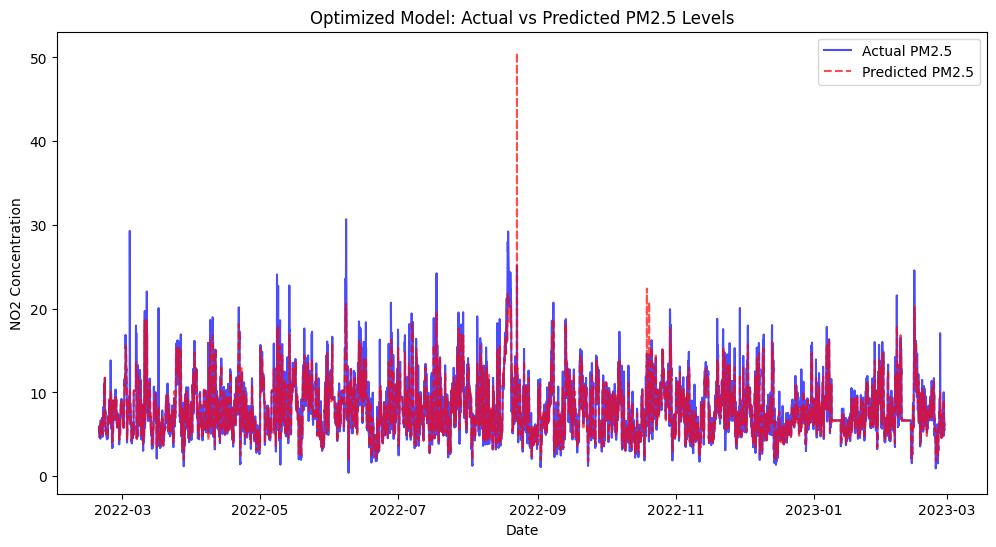

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual PM2.5", color="blue", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted PM2.5", color="red", linestyle="dashed", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.title("Optimized Model: Actual vs Predicted PM2.5 Levels")
plt.legend()
plt.show()

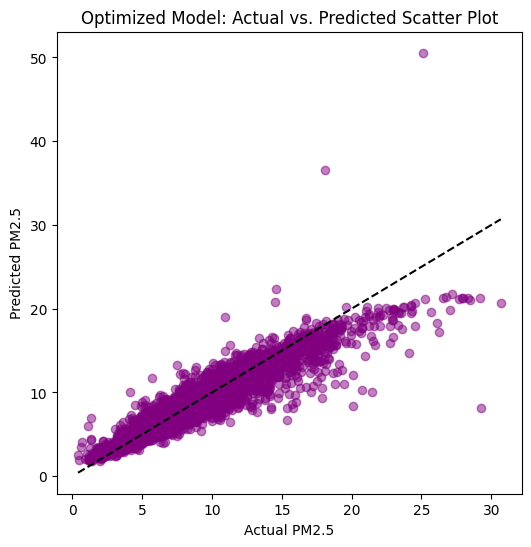

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="purple")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="dashed", color="black")  # 45-degree line
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Optimized Model: Actual vs. Predicted Scatter Plot")
plt.show()

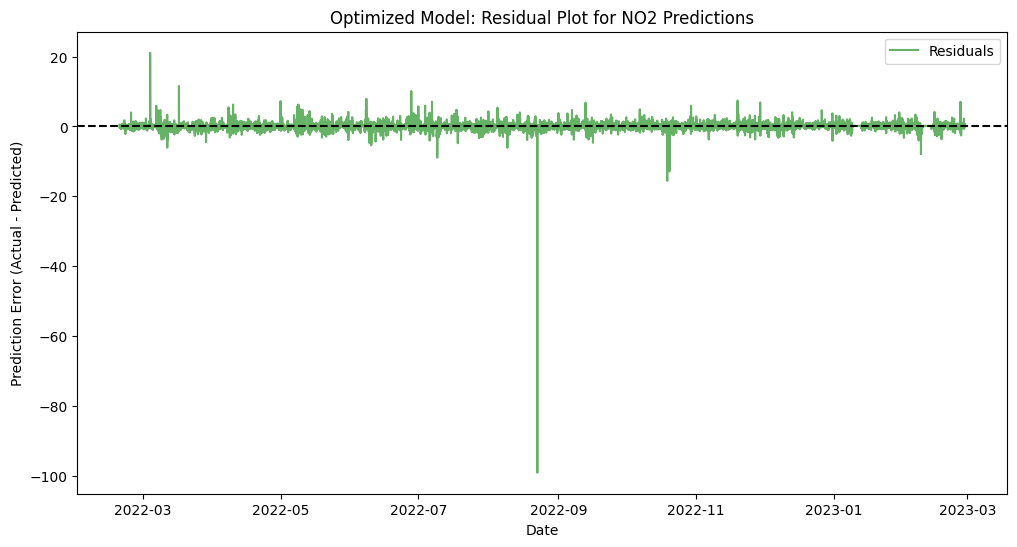

In [20]:
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, label="Residuals", color="green", alpha=0.6)
plt.axhline(0, linestyle="dashed", color="black")  # Zero error reference
plt.xlabel("Date")
plt.ylabel("Prediction Error (Actual - Predicted)")
plt.title("Optimized Model: Residual Plot for PM2.5 Predictions")
plt.legend()
plt.show()